In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py
from copy import deepcopy
import os
import json
import gc 
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.utils import dense_to_sparse

from sca import *
from utils import *
from models_uf import *


## load data

In [2]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cpu')

# # train data
# dfn3 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn3, "r") as handle:
#     X_tr = handle['training']['input'][...]
#     y_tr = handle['training']['xopt'][...]
    
# # validation data
# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]
      
        
#--- data---


# train data
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    assert num_ue==Hs.shape[1]

    for hidx in trange(Hs.shape[0]):
        edge_index_tr, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_tr.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_tr.append(xopt[hidx,...] )                   

y_tr = np.concatenate((y_tr))
X_tr = np.concatenate((X_tr))
y_tr = y_tr[~np.any(np.isnan(X_tr),-1)]     
X_tr = X_tr[~np.any(np.isnan(X_tr),-1)]


# validation data
dfn4 = '../../data/results_hataUrban.h5'
X_va, y_va = [],[]
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    for hidx in trange(Hs.shape[0]):
        edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_va.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_va.append(xopt[hidx,...] )

y_va = np.concatenate((y_va))
X_va = np.concatenate((X_va))
y_va = y_va[~np.any(np.isnan(X_va),-1)]     
X_va = X_va[~np.any(np.isnan(X_va),-1)]

#--- (end)---

        
# to toech tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_va = torch.from_numpy(y_va).float().to(device)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)



(51000, 17) torch.Size([51000, 4])
(51000, 17) torch.Size([51000, 4])


(array([9.8677e+04, 3.3392e+04, 3.6991e+04, 2.0696e+04, 9.4000e+03,
        3.3840e+03, 1.0410e+03, 3.2400e+02, 5.7000e+01, 3.8000e+01]),
 array([0.        , 0.01648412, 0.03296825, 0.04945238, 0.0659365 ,
        0.08242062, 0.09890475, 0.11538888, 0.131873  , 0.14835712,
        0.16484125], dtype=float32),
 <BarContainer object of 10 artists>)

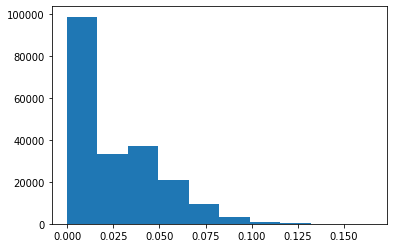

In [3]:
plt.hist(y_tr.numpy().flatten())

In [5]:
import numpy as np
np.random.random()

0.9507924254810692

## unfolded sca pipeline

In [113]:
from models_uf import *


device = torch.device('cpu')

in_size = num_ue**2 + num_ue + 1
out_size = num_ue

# h_sizes = [128, 64, 32, 16, 8]
# activs = ['elu', 'relu', 'elu', 'relu',  'elu']

h_sizes = [128, 64, 32, 32, 32, 16, 8]
h_sizes = [32, 16, 16, 16, 16, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 512
num_l = 3 # 1 2 3
nepochs = 200
learning_rate = 0.001

init = 'rand'
rseed= 42
loss_which= ['mse','wsee'] # wsee, mse
architecture = USCA_MLP # USCA_MLP_R, USCA_MLP
inner_optim='learned-mlp'

mstr = architecture.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
fix='large_%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
    mstr, k_fold, bs, num_l, learning_rate, init, '+'.join(loss_which), rseed)

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)
tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # clear cache
    torch.cuda.empty_cache()
    X_train, y_train, X_valid, y_valid, X_test, y_test, model = [None for _ in range(7)]
    gc.collect()
#     if k<1:
#         continue
#     # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    tr_wsee[k], va_wsee[k], te_wsee[k] = [],[],[]
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
    print('%d-fold: train opt wsee %.6f / val opt wsee %.6f / test opt wsee %.6f'%(
            k+1, tr_wsee_opt[k], va_wsee_opt[k], te_wsee_opt[k]))
    
    
    model = architecture(num_l, in_size, out_size, h_sizes, activs=activs, channel_info={'mu':mu, 'Pc':Pc},
                     dropout=0, inner_optim='learned-mlp').to(device)
    print(count_parameters(model))
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
#     raise
    
    
    best_wsee = 0
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss, running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = y_train[perm_i[i_s:i_e]]
            x = X_train[perm_i[i_s:i_e]]

            y_pred, gamma = model(x)
            
            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, x, mu, Pc, 'vector')

            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.mean(wsee).item()*num_ue

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss[k].append(running_loss/(i+1))
        tr_wsee[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        yp_valid, gamma = model( X_valid )        
        vloss = torch.mean((yp_valid[-1]-y_valid)**2).item()
        vobj = f_wsee_torch(yp_valid[-1], X_valid, mu, Pc, 'mean').item()
        va_loss[k].append(vloss) 
        va_wsee[k].append(vobj) 

        # test
        yp_test, gamma = model( X_test )
        tloss = torch.mean((yp_test[-1]-y_test)**2).item()
        tobj = f_wsee_torch(yp_test[-1], X_test, mu, Pc, 'mean').item()
        te_loss[k].append(tloss) 
        te_wsee[k].append(tobj)      

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        print('%d: train wsee %.6f / val wsee %.6f / test wsee %.6f'%(
            epoch, tr_wsee[k][-1], va_wsee[k][-1], te_wsee[k][-1]), end=' ') 
        
        # save 
        if va_wsee[k][-1] > best_wsee:
            best_wsee = va_wsee[k][-1]
            torch.save(model, './results/%s.%df.%dep.pt'%(fix, k, epoch))
            print('*')
        else:
            print()
        
        
#     break




2020-12-24 05:46:26 | torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])
2020-12-24 05:46:26 | 1-fold: train opt wsee 7.876275 / val opt wsee 7.827026 / test opt wsee 9.227342
2020-12-24 05:46:26 | 14952


2020-12-24 05:46:27 | 0: train loss 0.149603 / val loss 0.070966 / test loss 0.111379
2020-12-24 05:46:27 | 0: train wsee 4.326755 / val wsee 4.708954 / test wsee 4.870224 2020-12-24 05:46:27 | *
2020-12-24 05:46:28 | 1: train loss 0.012694 / val loss 0.002648 / test loss 0.003826
2020-12-24 05:46:28 | 1: train wsee 5.377464 / val wsee 6.180585 / test wsee 6.366382 2020-12-24 05:46:28 | *
2020-12-24 05:46:28 | 2: train loss 0.007242 / val loss 0.009368 / test loss 0.021765
2020-12-24 05:46:28 | 2: train wsee 6.704770 / val wsee 7.038892 / test wsee 7.630698 2020-12-24 05:46:28 | *
2020-12-24 05:46:29 | 3: train loss 0.010411 / val loss 0.000233 / test loss 0.000380
2020-12-24 05:46:29 | 3: train wsee 7.344210 / val wsee 7.703219 / test wsee 8.857449 2020-12-24 05:46:29 | *
2020-12-24 05:46:30 | 4: train loss 0.000233 / val loss 0.000219 / test loss 0.000368
2020-12-24 05:46:30 | 4: train wsee 7.758443 / val wsee 7.717676 / test wsee 8.870830 2020-12-24 05:46:30 | *
2020-12-24 05:46:30 

2020-12-24 05:46:56 | 42: train loss 0.000160 / val loss 0.000156 / test loss 0.000333
2020-12-24 05:46:56 | 42: train wsee 7.792647 / val wsee 7.757791 / test wsee 8.917451 2020-12-24 05:46:56 | *
2020-12-24 05:46:56 | 43: train loss 0.000156 / val loss 0.000151 / test loss 0.000325
2020-12-24 05:46:56 | 43: train wsee 7.807433 / val wsee 7.758138 / test wsee 8.915549 2020-12-24 05:46:56 | *
2020-12-24 05:46:57 | 44: train loss 0.000154 / val loss 0.000152 / test loss 0.000338
2020-12-24 05:46:57 | 44: train wsee 7.803215 / val wsee 7.757751 / test wsee 8.893500 2020-12-24 05:46:57 | 
2020-12-24 05:46:58 | 45: train loss 0.000154 / val loss 0.004174 / test loss 0.010272
2020-12-24 05:46:58 | 45: train wsee 7.816012 / val wsee 7.746879 / test wsee 8.884131 2020-12-24 05:46:58 | 
2020-12-24 05:46:58 | 46: train loss 0.000163 / val loss 0.000150 / test loss 0.000324
2020-12-24 05:46:58 | 46: train wsee 7.806415 / val wsee 7.762988 / test wsee 8.919412 2020-12-24 05:46:58 | *
2020-12-24 0

2020-12-24 05:47:24 | 84: train loss 0.000120 / val loss 0.000121 / test loss 0.000303
2020-12-24 05:47:24 | 84: train wsee 7.829574 / val wsee 7.783408 / test wsee 8.984974 2020-12-24 05:47:24 | 
2020-12-24 05:47:25 | 85: train loss 0.000129 / val loss 0.000117 / test loss 0.000366
2020-12-24 05:47:25 | 85: train wsee 7.830786 / val wsee 7.785866 / test wsee 8.972866 2020-12-24 05:47:25 | *
2020-12-24 05:47:26 | 86: train loss 0.000121 / val loss 0.000118 / test loss 0.000310
2020-12-24 05:47:26 | 86: train wsee 7.828284 / val wsee 7.783612 / test wsee 8.972201 2020-12-24 05:47:26 | 
2020-12-24 05:47:27 | 87: train loss 0.000128 / val loss 0.000124 / test loss 0.000360
2020-12-24 05:47:27 | 87: train wsee 7.828136 / val wsee 7.783817 / test wsee 8.977473 2020-12-24 05:47:27 | 
2020-12-24 05:47:27 | 88: train loss 0.000141 / val loss 0.000119 / test loss 0.000325
2020-12-24 05:47:27 | 88: train wsee 7.831462 / val wsee 7.782786 / test wsee 8.977662 2020-12-24 05:47:27 | 
2020-12-24 05:

2020-12-24 05:47:53 | 126: train loss 0.000107 / val loss 0.000110 / test loss 0.000308
2020-12-24 05:47:53 | 126: train wsee 7.842234 / val wsee 7.785378 / test wsee 8.984241 2020-12-24 05:47:53 | 
2020-12-24 05:47:54 | 127: train loss 0.000106 / val loss 0.000108 / test loss 0.000293
2020-12-24 05:47:54 | 127: train wsee 7.841153 / val wsee 7.792706 / test wsee 8.982631 2020-12-24 05:47:54 | 
2020-12-24 05:47:55 | 128: train loss 0.000107 / val loss 0.000103 / test loss 0.000300
2020-12-24 05:47:55 | 128: train wsee 7.846088 / val wsee 7.794522 / test wsee 8.981659 2020-12-24 05:47:55 | *
2020-12-24 05:47:55 | 129: train loss 0.000107 / val loss 0.000103 / test loss 0.000300
2020-12-24 05:47:55 | 129: train wsee 7.838385 / val wsee 7.794719 / test wsee 8.987045 2020-12-24 05:47:55 | *
2020-12-24 05:47:56 | 130: train loss 0.000104 / val loss 0.000102 / test loss 0.000305
2020-12-24 05:47:56 | 130: train wsee 7.839323 / val wsee 7.793859 / test wsee 8.986457 2020-12-24 05:47:56 | 
202

2020-12-24 05:48:22 | 168: train loss 0.000096 / val loss 0.000097 / test loss 0.001794
2020-12-24 05:48:22 | 168: train wsee 7.840372 / val wsee 7.798386 / test wsee 8.990329 2020-12-24 05:48:22 | 
2020-12-24 05:48:23 | 169: train loss 0.000096 / val loss 0.000098 / test loss 0.001440
2020-12-24 05:48:23 | 169: train wsee 7.849608 / val wsee 7.798133 / test wsee 8.989532 2020-12-24 05:48:23 | 
2020-12-24 05:48:24 | 170: train loss 0.000100 / val loss 0.000096 / test loss 0.001665
2020-12-24 05:48:24 | 170: train wsee 7.831872 / val wsee 7.793964 / test wsee 8.978427 2020-12-24 05:48:24 | 
2020-12-24 05:48:24 | 171: train loss 0.000097 / val loss 0.000093 / test loss 0.001752
2020-12-24 05:48:24 | 171: train wsee 7.846658 / val wsee 7.798303 / test wsee 8.985774 2020-12-24 05:48:24 | 
2020-12-24 05:48:25 | 172: train loss 0.000094 / val loss 0.000094 / test loss 0.000362
2020-12-24 05:48:25 | 172: train wsee 7.847329 / val wsee 7.797531 / test wsee 8.989284 2020-12-24 05:48:25 | 
2020-

2020-12-24 05:48:45 | 0: train loss 0.037540 / val loss 0.007282 / test loss 0.010020
2020-12-24 05:48:45 | 0: train wsee 4.857701 / val wsee 5.491285 / test wsee 5.820022 2020-12-24 05:48:45 | *
2020-12-24 05:48:45 | 1: train loss 0.019776 / val loss 0.035923 / test loss 0.084861
2020-12-24 05:48:45 | 1: train wsee 5.724944 / val wsee 6.077446 / test wsee 6.572041 2020-12-24 05:48:45 | *
2020-12-24 05:48:46 | 2: train loss 0.008180 / val loss 0.016058 / test loss 0.020760
2020-12-24 05:48:46 | 2: train wsee 6.341236 / val wsee 6.619740 / test wsee 7.197819 2020-12-24 05:48:46 | *
2020-12-24 05:48:47 | 3: train loss 0.008245 / val loss 0.004614 / test loss 0.015829
2020-12-24 05:48:47 | 3: train wsee 6.651829 / val wsee 6.622128 / test wsee 7.220849 2020-12-24 05:48:47 | *
2020-12-24 05:48:47 | 4: train loss 0.006247 / val loss 0.000762 / test loss 0.001719
2020-12-24 05:48:47 | 4: train wsee 6.787484 / val wsee 6.801331 / test wsee 7.350976 2020-12-24 05:48:47 | *
2020-12-24 05:48:48 

2020-12-24 05:49:13 | 42: train loss 0.000143 / val loss 0.000149 / test loss 0.000491
2020-12-24 05:49:13 | 42: train wsee 7.758247 / val wsee 7.809268 / test wsee 8.916377 2020-12-24 05:49:13 | 
2020-12-24 05:49:14 | 43: train loss 0.000139 / val loss 0.000147 / test loss 0.000369
2020-12-24 05:49:14 | 43: train wsee 7.760063 / val wsee 7.810507 / test wsee 8.931511 2020-12-24 05:49:14 | 
2020-12-24 05:49:15 | 44: train loss 0.000139 / val loss 0.000142 / test loss 0.000443
2020-12-24 05:49:15 | 44: train wsee 7.767995 / val wsee 7.812386 / test wsee 8.928667 2020-12-24 05:49:15 | 
2020-12-24 05:49:15 | 45: train loss 0.000166 / val loss 0.000213 / test loss 0.000394
2020-12-24 05:49:15 | 45: train wsee 7.754303 / val wsee 7.787510 / test wsee 8.883263 2020-12-24 05:49:15 | 
2020-12-24 05:49:16 | 46: train loss 0.000169 / val loss 0.000142 / test loss 0.000350
2020-12-24 05:49:16 | 46: train wsee 7.761940 / val wsee 7.813949 / test wsee 8.929849 2020-12-24 05:49:16 | *
2020-12-24 05:

2020-12-24 05:49:42 | 84: train loss 0.000104 / val loss 0.000130 / test loss 0.000677
2020-12-24 05:49:42 | 84: train wsee 7.782758 / val wsee 7.812085 / test wsee 8.929153 2020-12-24 05:49:42 | 
2020-12-24 05:49:43 | 85: train loss 0.000107 / val loss 0.000118 / test loss 0.000413
2020-12-24 05:49:43 | 85: train wsee 7.775074 / val wsee 7.825072 / test wsee 8.943635 2020-12-24 05:49:43 | 
2020-12-24 05:49:44 | 86: train loss 0.000110 / val loss 0.000111 / test loss 0.000601
2020-12-24 05:49:44 | 86: train wsee 7.782674 / val wsee 7.830208 / test wsee 8.951686 2020-12-24 05:49:44 | 
2020-12-24 05:49:44 | 87: train loss 0.000146 / val loss 0.000108 / test loss 0.000375
2020-12-24 05:49:44 | 87: train wsee 7.777574 / val wsee 7.834339 / test wsee 8.962000 2020-12-24 05:49:44 | *
2020-12-24 05:49:45 | 88: train loss 0.000197 / val loss 0.000107 / test loss 0.000348
2020-12-24 05:49:45 | 88: train wsee 7.784771 / val wsee 7.836416 / test wsee 8.959353 2020-12-24 05:49:45 | *
2020-12-24 05

2020-12-24 05:50:11 | 126: train loss 0.000093 / val loss 0.000094 / test loss 0.000323
2020-12-24 05:50:11 | 126: train wsee 7.796522 / val wsee 7.846240 / test wsee 8.979643 2020-12-24 05:50:11 | 
2020-12-24 05:50:12 | 127: train loss 0.000100 / val loss 0.000097 / test loss 0.000320
2020-12-24 05:50:12 | 127: train wsee 7.791521 / val wsee 7.844790 / test wsee 8.979826 2020-12-24 05:50:12 | 
2020-12-24 05:50:13 | 128: train loss 0.000089 / val loss 0.000094 / test loss 0.000347
2020-12-24 05:50:13 | 128: train wsee 7.798526 / val wsee 7.845850 / test wsee 8.979464 2020-12-24 05:50:13 | 
2020-12-24 05:50:13 | 129: train loss 0.000092 / val loss 0.000095 / test loss 0.000356
2020-12-24 05:50:13 | 129: train wsee 7.798362 / val wsee 7.846055 / test wsee 8.977378 2020-12-24 05:50:13 | 
2020-12-24 05:50:14 | 130: train loss 0.000091 / val loss 0.000099 / test loss 0.000332
2020-12-24 05:50:14 | 130: train wsee 7.783730 / val wsee 7.840824 / test wsee 8.968480 2020-12-24 05:50:14 | 
2020-

2020-12-24 05:50:40 | 168: train loss 0.000078 / val loss 0.000082 / test loss 0.000290
2020-12-24 05:50:40 | 168: train wsee 7.802159 / val wsee 7.851420 / test wsee 8.987822 2020-12-24 05:50:40 | 
2020-12-24 05:50:41 | 169: train loss 0.000077 / val loss 0.000081 / test loss 0.000293
2020-12-24 05:50:41 | 169: train wsee 7.803196 / val wsee 7.849958 / test wsee 8.980820 2020-12-24 05:50:41 | 
2020-12-24 05:50:42 | 170: train loss 0.000091 / val loss 0.000088 / test loss 0.000303
2020-12-24 05:50:42 | 170: train wsee 7.807458 / val wsee 7.848351 / test wsee 8.981476 2020-12-24 05:50:42 | 
2020-12-24 05:50:42 | 171: train loss 0.000082 / val loss 0.000083 / test loss 0.000286
2020-12-24 05:50:42 | 171: train wsee 7.797889 / val wsee 7.850761 / test wsee 8.987888 2020-12-24 05:50:42 | 
2020-12-24 05:50:43 | 172: train loss 0.000078 / val loss 0.000084 / test loss 0.000286
2020-12-24 05:50:43 | 172: train wsee 7.804858 / val wsee 7.849741 / test wsee 8.992974 2020-12-24 05:50:43 | 
2020-

In [12]:
len(yy)

4

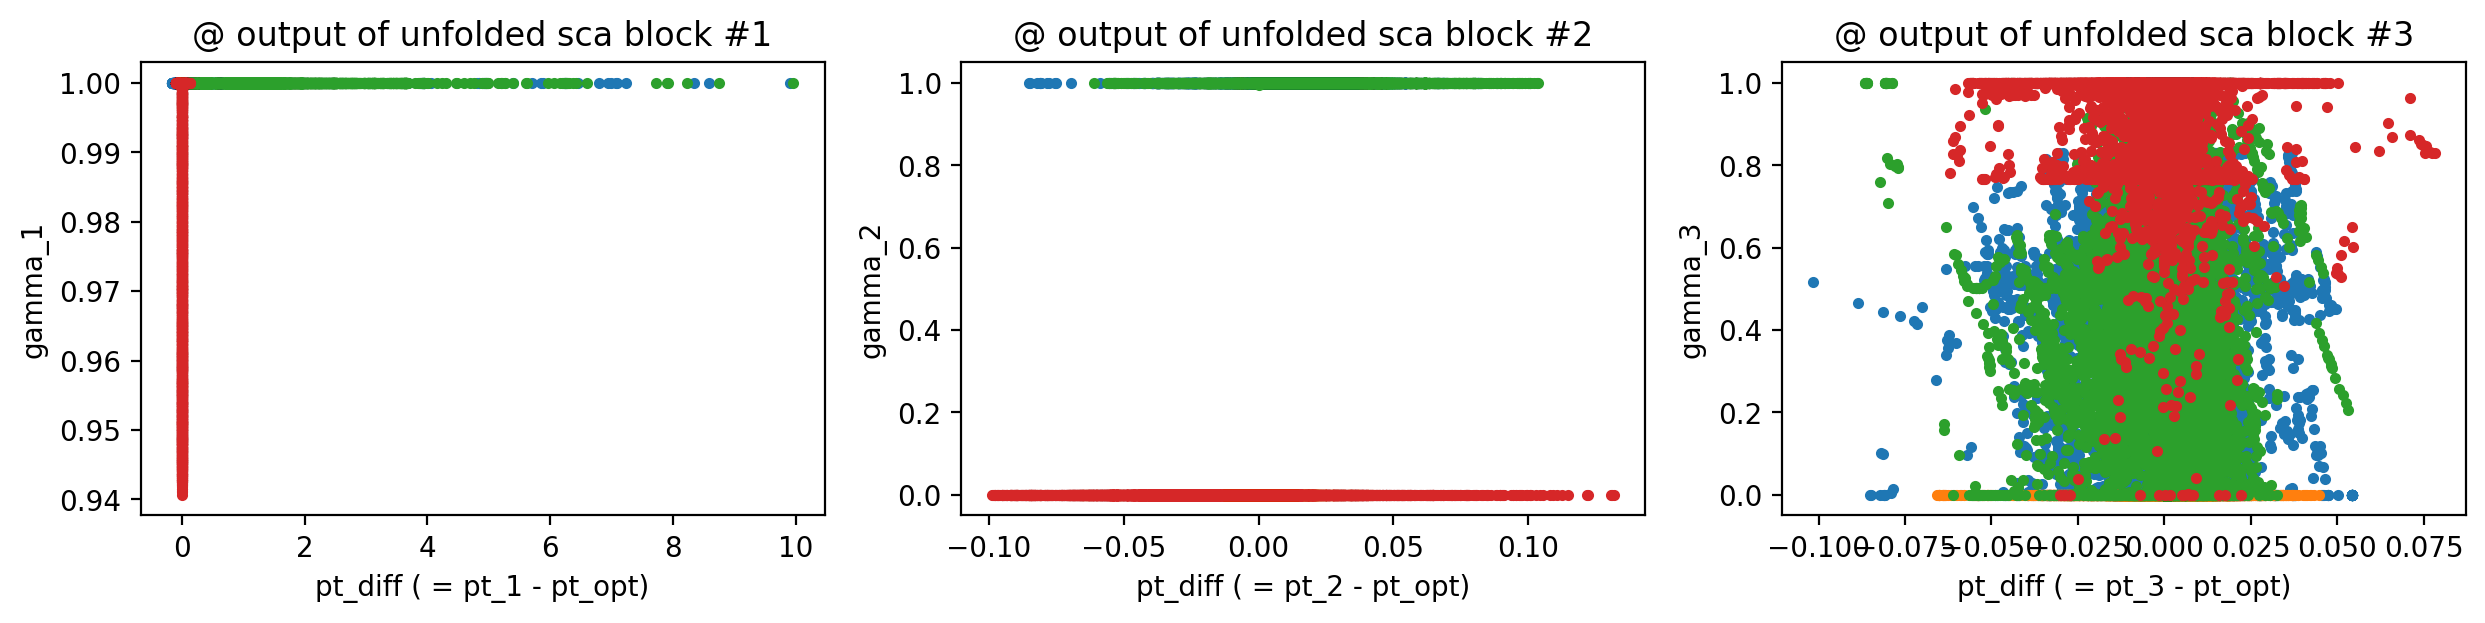

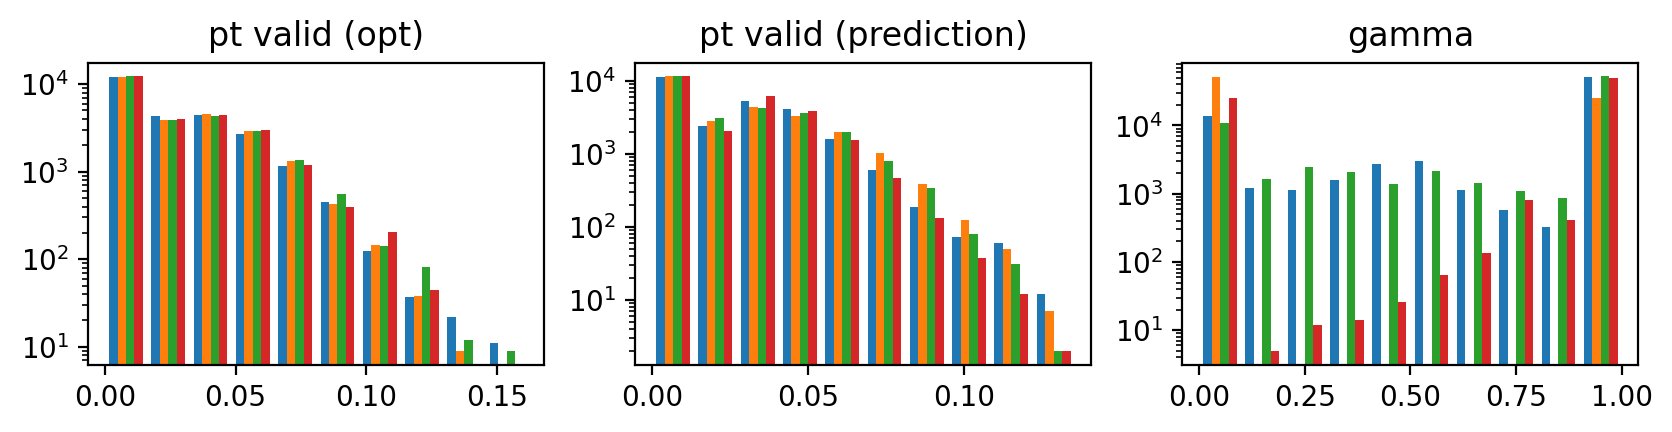

37996

In [114]:
yy, gg = model(X_valid)
y_diff = [yy[i+1] - y_valid for i in range(3)]

fig, ax = plt.subplots(1,3,figsize=(15,3), dpi=200)

for i in range(len(y_diff)):
    ax[i].plot(y_diff[i].detach().numpy(), gg[i].detach().numpy(),'.', alpha=1)
    ax[i].set_title('@ output of unfolded sca block #%d'%(i+1))
    ax[i].set_xlabel('pt_diff ( = pt_%d - pt_opt)'%(i+1))
    ax[i].set_ylabel('gamma_%d'%(i+1))
plt.show()

##

plt.figure(figsize=(10,2), dpi=200)

plt.subplot(131)
plt.hist(y_valid.numpy())#, bins=30)
plt.yscale('log')
plt.title('pt valid (opt)')

plt.subplot(132)
yyy = deepcopy(yy[-1].detach().numpy())
# yyy[yyy>1.6]=0
plt.hist(yyy)#, bins=30)
plt.yscale('log')
plt.title('pt valid (prediction)')

ggg = deepcopy(np.array([gi.detach().numpy() for gi in gg]))
plt.subplot(133)
plt.hist(ggg.reshape(-1,ggg.shape[-1]))#, bins=30)
plt.yscale('log')
plt.title('gamma')

plt.show()

yyy,ggg = None, None
gc.collect()

In [10]:
moel = torch.save(model, './results/%s.%df.%dep.pt'%(fix, k, epoch))


In [42]:
va_wsee[k][-1], va_wsee[k][-2]

(7.338975429534912, 7.383155822753906)

In [90]:
import os
import json

list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

save_name  = save_dir+'log.%dfcv.json'%k_fold
with open(save_name, 'w') as fp:
    evals = {'tr_loss':tr_loss, 'va_loss':va_loss, 'te_loss':te_loss, 
             'tr_wsee':tr_wsee, 'va_wsee':va_wsee, 'te_wsee':te_wsee}
    json.dump(evals, fp)
    
save_name

'./results/large_USCA.MLP+learned.mlp_kf+2_bs+512_nl+3_lr+1.000000e-03_pinit+rand_loss+mse+wsee_rseed+42/log.2fcv.json'

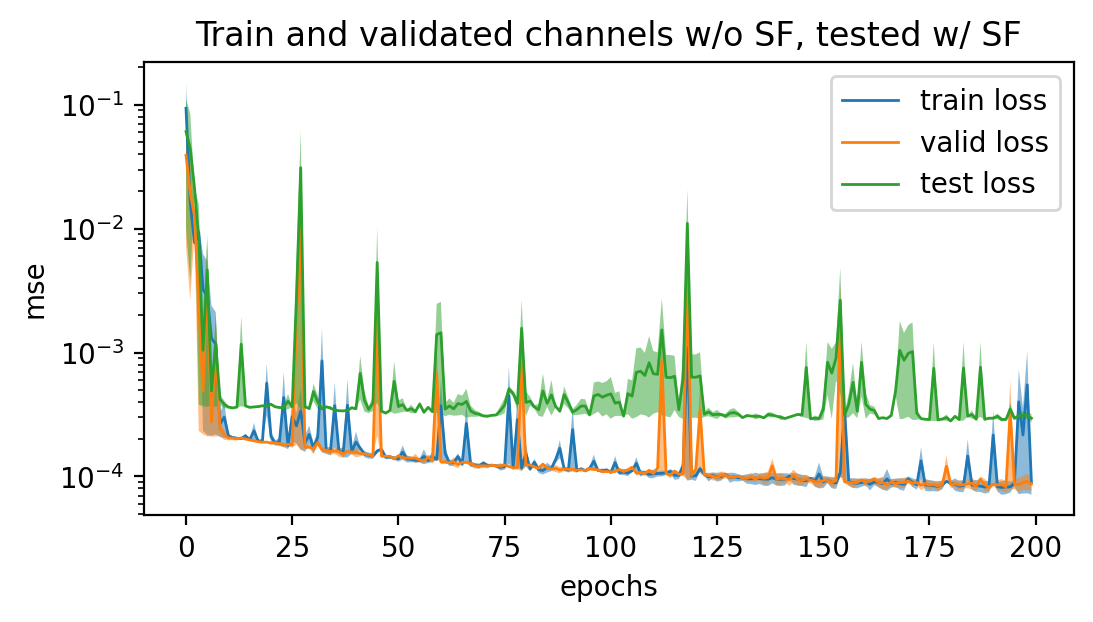

In [115]:

plt.figure(figsize=(6,3),  dpi=200)

for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

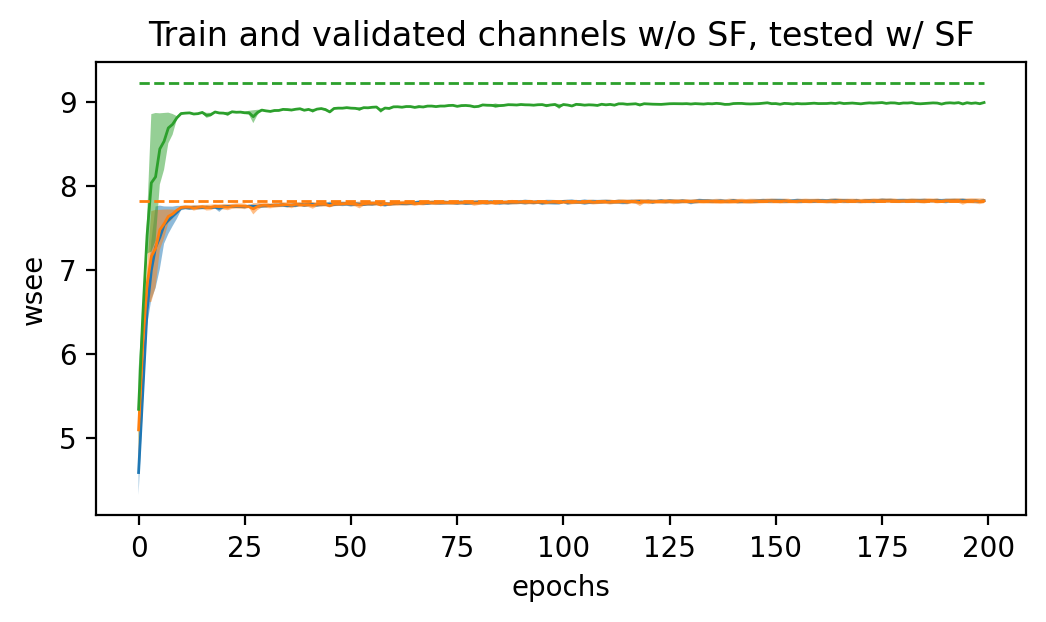

In [116]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(6,3),  dpi=200)

# for i, (ph, loss) in enumerate(zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss])):
for i, (ph, loss) in enumerate(zip(["train", "valid", "test"],[tr_wsee, va_wsee, te_wsee])):

#     plt.plot(range(epoch+1), list(loss.values())[-1], '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s wsee'%ph, color=colors[i])
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

plt.plot([0, epoch], [va_wsee_opt[0]]*2, '--', linewidth=1, label='val/train wsee (opt)',color=colors[1])
plt.plot([0, epoch], [te_wsee_opt[0]]*2, '--', linewidth=1, label='test opt wsee (opt)',color=colors[2])



plt.xlabel('epochs')
plt.ylabel('wsee')
# plt.legend()

# plt.yscale('log')
# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [18]:
list(va_loss.values())[-1][-1], list(va_wsee.values())[-1][-1]

(0.0006210813880898058, 7.505840301513672)

In [19]:
f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()

7.876275062561035

In [31]:
ggg

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

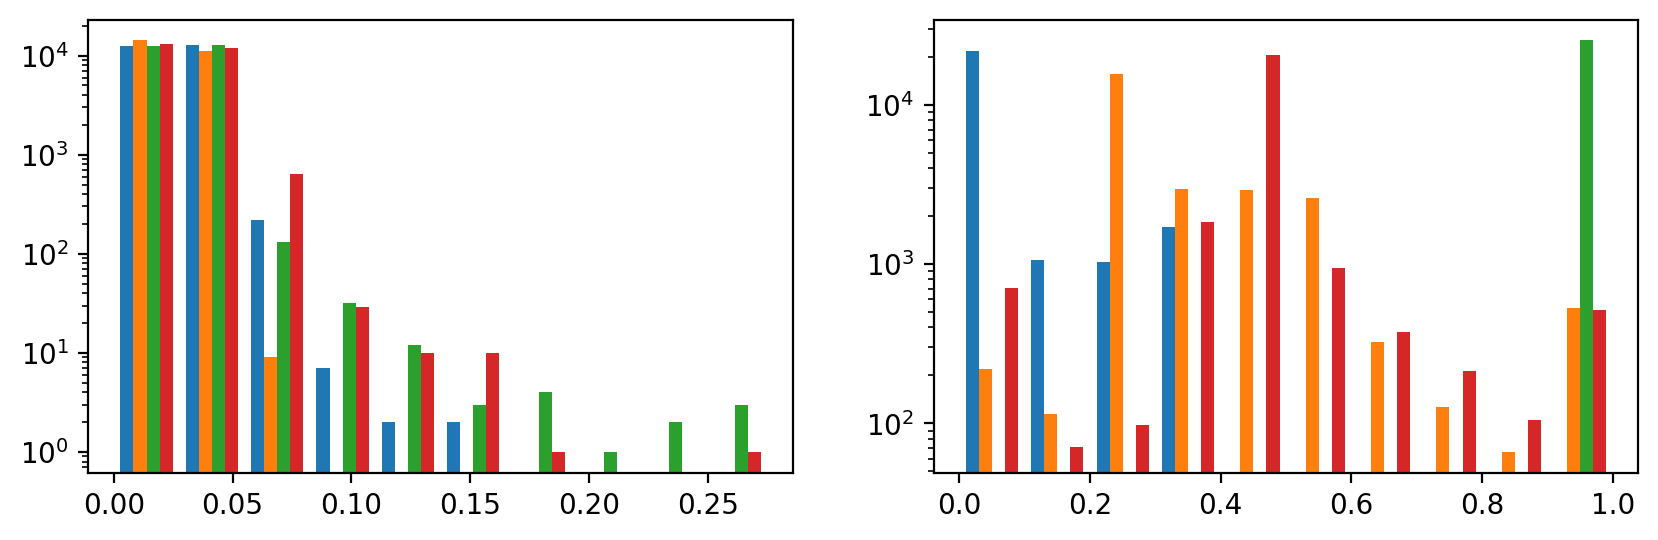

In [ ]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cuda')


dfn4 = '../../data/results_hataUrban.h5'
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    print(xopt.shape)
    
    xx = np.empty((Hs.shape[0]*len(Plin),Hs.shape[1]*Hs.shape[2]+1))
    yy = np.empty((Hs.shape[0]*len(Plin),num_ue))
    
    i=0
    for hidx in trange(Hs.shape[0]):
#         h = Hs[hidx]
        print(Hs[hidx])
        for pidx in range(len(Plin)):
            p_max = Plin[pidx]
            edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
            xx[i] = np.log10(np.concatenate((h*p_max, [p_max])).reshape((1,-1))).astype(float)
            yy[i] = xopt[hidx,pidx,...]
            i+=1
            
            print(yy[i], p_max)
        raise

# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]

        
#--- (end)---

        
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)


In [ ]:
# test
x =  torch.from_numpy(X_va_).float()#.to(device) 
with torch.no_grad():
    y_pred, gamma = model( x )
y_true = torch.from_numpy(y_va).float()#.to(device)
print(x.shape, y_pred.shape, y_true.shape)

wsee_test_opt = f_wsee_torch(y_true, x, mu, Pc, 'mean').numpy()
wsee_test_pred = f_wsee_torch(y_pred, x, mu, Pc, 'mean').numpy()

print('true:', wsee_test_opt, 'pred:', wsee_test_pred)

In [ ]:
y_va

In [ ]:
y_true, y_pred, 10**x[:,-1]

In [ ]:
plt.plot(10**x[:,-1][:300])

In [ ]:
plt.hist(y_true.numpy().flatten())
plt.show()
plt.hist(y_pred.numpy().flatten())
plt.show()
plt.hist(10**x[:,-1].numpy().flatten())
plt.show()


In [ ]:
it_count1  = []

def SCA(h, mu, Pc, Pmax, pt = None, MaxIter = 10000, SolverMaxIter = 1000,
         parm_alpha = 1e-8, parm_beta = 0.01, 
         RelTolFun = 1e-12, RelTolVal = 1e-12, InnerOpt='sgd'):
    """
    InnerOpt: sgd, cvx, ...
    Init    : last, full, ...
    """

    if pt is None:
        pt = np.full(h.shape[-1], Pmax)

    def f(p): # verified
        s = h * p # (4,4) * (4,) --> (4,4)
        
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        ee = rates / (mu * p + Pc)

        return np.sum(ee)

    def gradr(p): # verified
        s = h * p
        tmp = 1 + np.sum(s, axis=-1) # 1 + sum beta + a
        tmp2 = tmp - np.diag(s)
        fac = np.diag(s) / (tmp * tmp2)
        
        grad = h.copy()      
        grad = -(fac * grad.T).T
    
        grad[np.diag_indices_from(grad)] = 1/tmp * np.diag(h)#tmp2/(tmp*tmp2) * np.diag(h)

        return grad

    def gradf(p): # verified
        tmp = 1 / (mu * p + Pc)
        gr = gradr(p)
        
        t1 = np.sum((gr.T * tmp).T, axis=0)

        s = h * p
        direct = np.diag(s)
        ifn = 1 + np.sum(s, axis=-1) - direct
        rates = np.log(1+direct/ifn)
        
        t2 = mu * rates * tmp**2

        return t1 - t2

    # gradient step parameter
    if InnerOpt.lower() == "sgd":
        inner_opt = inner_optim_sgd
        kargws = {"learning_rate":.1}
        
    elif InnerOpt.lower() == "cvx":
        inner_opt = inner_optim_cvx
        kargws = {"verbose": False}
        
    else:
        raise NotImplemented
        
        
    OBJ, PT = [f(pt)],[pt]
    cnt = 0
    while True:
                
        cnt += 1
        pvar = inner_opt(pt, h, Pmax, Pc, mu, eps=1e-8, max_iters=SolverMaxIter, **kargws)
                
        # calculate gradient step
        Bpt = pvar - pt
        gamma = 1

        old_obj = f(pt)
        old_pt = pt
        while f(pt + gamma * Bpt) < old_obj + parm_alpha * gamma * gradf(pt) @ Bpt:
            gamma *= parm_beta

#         pt = np.clip(gamma * Bpt + pt, 0, Pmax)
        pt += gamma * Bpt
        obj = f(pt)
        
        OBJ.append(obj)
        PT.append(pt)

        with np.errstate(divide='ignore'):
            if abs(obj/old_obj - 1) < RelTolFun and np.linalg.norm(pt-old_pt, np.inf) / np.linalg.norm(pt, np.inf) < RelTolVal:
                break
        
        if cnt > MaxIter:
            print('MaxIter')
            break

    it_count1.append(cnt)
    return (OBJ, PT)

In [ ]:
it_count1

In [ ]:

num_ue = 7
mu = 4
Pc = 1

INITS = ['last','full']#,'rand']
OPTIM = ['sgd', 'cvx']

INNER_MAXIT = [6]#, 2, 5, 10, 15, 20, 35, 50, 100, 150, 200]
# outer_maxit = [1, 2, 5, 10, 20, 50, 150]

log_outiters = dict(zip(INITS,[[] for _ in INITS]))
log_all = dict(zip(OPTIM,[[] for _ in OPTIM]))

for opt in OPTIM:
    
    for im in INNER_MAXIT:

        log_monitor = {
            'objective':dict(zip(INITS,[[] for _ in INITS])),
            'pwr_alloc':dict(zip(INITS,[[] for _ in INITS]))
        }


        dfn1 = '../../data/wsee%d-processed.h5'%num_ue
        with h5py.File(dfn1, "r") as f:
            PdB = f['input']['PdB'][...] # this is fixed

        assert np.allclose(PdB, np.array(range(-30,20+1,1)))
        Plin = 10**(np.asarray(PdB/10))

        dfn2 = '../../data_my/channels-%d.h5'%num_ue
    #     dfn2 = '../../data_my/channels-HataSuburban-%d.h5'%num_ue
        with h5py.File(dfn2, "r") as f:
            # Get the data
            data = {k:{kk: v[:] for kk,v in f[k].items()} for k in f.keys()}

            Hs = data['input']['channel_to_noise_matched']

            for hidx in tqdm([456]):#trange(Hs.shape[0]):#tqdm(np.random.permutation(Hs.shape[0])):

                h = Hs[hidx]
                pt = None

                p_perm = list(range(len(Plin)))#
                for pidx in tqdm(p_perm, desc=str(im)):

                    p = Plin[pidx]

                    O = dict(zip(INITS,[[] for _ in INITS]))
                    P = dict(zip(INITS,[[] for _ in INITS]))
                    
                    for istr in INITS: #['last','full']
                        if istr == 'last' and pt is not None:
                            p0 = pt
                        elif istr == 'full' or pt is None:
                            p0 = np.full(num_ue, p)
                        else:
                            raise NotImplemented
                            
                        try:
                            assert istr == 'last' # dont do full 
                            O[istr], P[istr] = SCA(h, mu, Pc, Pmax = p, pt = p0, 
                                                    SolverMaxIter=im, MaxIter = 1000, 
                                                    parm_alpha = 1e-8, parm_beta = 0.01, 
                                                    RelTolFun = 1e-12, RelTolVal = 1e-12, 
                                                    InnerOpt=opt)
                        except:
                            O[istr], P[istr] = [-np.inf], [np.full(num_ue, p)]
                            
                    # best init
                    bstr = max(O, key=lambda key: O[key][-1]) 
                    pt = P[bstr][-1]

                    print('%s init is best!'%bstr.upper(), 
                          '; objective ee =', O[bstr][-1], 
                          '; #outer iters =', len(O[bstr]),
                          '; pt =', pt, '; Pmax =', p)

                    [log_monitor['objective'][k].append(v) for k,v in O.items()]
                    [log_monitor['pwr_alloc'][k].append(v) for k,v in P.items()]

                break

            lens = {}
            for k,v in log_monitor['objective'].items():
                lens[k] = np.array([len(vv) for vv in v])

            eeval = {}
            for k,v in log_monitor['objective'].items():
                eeval[k] = np.array([vv[-1] for vv in v])

            for k,v in log_monitor['objective'].items():
                length = [len(vv) for vv in v]
                ee = eeval[k][eeval[k]>=0]

                print(k)
                print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
                print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
                print()
                log_outiters[k].append(length)
                
    log_all[opt] = deepcopy(log_monitor)


In [38]:
gg

[tensor([[0.0055, 1.0000, 1.0000, 1.0000],
         [0.0089, 1.0000, 1.0000, 1.0000],
         [0.0106, 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<MaxBackward2>),
 tensor([[1.0000, 0.0000, 0.0000, 0.0169],
         [1.0000, 0.0000, 0.0000, 0.0170],
         [1.0000, 0.0000, 0.0000, 0.0172],
         ...,
         [1.0000, 0.0000, 0.0000, 0.0762],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<MaxBackward2>),
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], grad_fn=<MaxBackward2>)]

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=200)
for i, (k,v) in enumerate(log_outiters.items()): 
    ax[i].boxplot(np.array(v).T, showmeans=True)

    ax[i].set_title(k)
    ax[i].set_xticks(range(1,len(INNER_MAXIT)+1))
    ax[i].set_xticklabels(INNER_MAXIT)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('# inner iters')
    
ax[0].set_ylabel('# outer iters')
# plt.legend()
plt.show()

In [ ]:

# visualize channels and plin

H = np.array(h)
np.fill_diagonal(H, 0)

G = nx.from_numpy_matrix(H, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])

edges = G.edges()
weights = [G[u][v]['weight']/50 for u,v in edges]

plt.figure(figsize=(13,4))
plt.subplot(121)
nx.draw(G, pos, node_size=1000,font_size=14,
        width=weights, with_labels=True) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.subplot(122)
plt.plot(Plin,'.')
plt.ylabel('P_max')
plt.show()




In [ ]:
plt.figure(figsize=(10,4), dpi=200)

plt.plot([v[-1] for v in log_all['sgd']['objective']['last']], '.', alpha=.7, label='sgd')
plt.plot([v[-1] for v in log_all['cvx']['objective']['last']], '.', alpha=.7, label='cvx')

plt.legend()
plt.show()

In [ ]:
lens = {}
for k,v in log_monitor['objective'].items():
    lens[k] = np.array([len(vv) for vv in v])

eeval = {}
for k,v in log_monitor['objective'].items():
    eeval[k] = np.array([vv[-1] for vv in v])
    
for k,v in log_monitor['objective'].items():
    length = [len(vv) for vv in v]
    ee = eeval[k][eeval[k]>=0]
    
    print(k)
    print('#iters: %.2f'%np.mean(length), "(+- %.2f"%np.std(length), ")")
    print('#eeval: %.2f'%np.mean(ee), "(+- %.2f"%np.std(ee), ")")
    print()
    
    
# # plot ee
# for k,v in log_monitor['objective'].items():
#     plt.plot(p_perm, eeval[k],'.', label=k, alpha=.7)
# #     plt.plot(eeval[k],'.', label=k, alpha=.7)
# plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
# plt.legend()
# plt.show()

# MLP

In [77]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F

from tqdm.auto import trange

# layer = ([128, 64, 32, 16, 8], ['elu', 'relu', 'elu', 'relu', 'elu'])
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # permutation
        self.fc1 = nn.Linear(input_size**2+1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, input_size)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.elu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.relu(self.fc4(x))
        x = self.elu(self.fc5(x))
        x = self.fc6(x)
        
        x = scale_to_range(x, [0, x[:,-1]])
        
        return x
    
    
class GCN(torch.nn.Module):
    def __init__(self, dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim, 32)
        self.conv2 = GCNConv(32, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 16)
        self.conv5 = GCNConv(16, 8)
        self.conv6 = GCNConv(8, dim)
#         self.final = nn.Linear(dim, dim) 

    def forward(self, x, edge_index, edge_weights):
#         x, edge_index = data.x, data.edge_index

        x = F.elu(self.conv1(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv3(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.relu(self.conv4(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)
        
        x = F.elu(self.conv5(x, edge_index, edge_weight=edge_weights))
#         x = F.dropout(x, training=self.training)

        x = self.conv6(x, edge_index, edge_weight=edge_weights)

#         return F.log_softmax(x, dim=1)
        return x#self.final(x)


    
count_parameters(MLP(num_ue))
count_parameters(GCN(1))

Total Trainable Params: 13340
Total Trainable Params: 13729


13729

In [83]:
count_parameters(model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
| sca.0.gamma.hidden.0.weight  |    2688    |
|  sca.0.gamma.hidden.0.bias   |    128     |
| sca.0.gamma.hidden.2.weight  |    8192    |
|  sca.0.gamma.hidden.2.bias   |     64     |
| sca.0.gamma.hidden.5.weight  |    2048    |
|  sca.0.gamma.hidden.5.bias   |     32     |
| sca.0.gamma.hidden.8.weight  |    1024    |
|  sca.0.gamma.hidden.8.bias   |     32     |
| sca.0.gamma.hidden.11.weight |    1024    |
|  sca.0.gamma.hidden.11.bias  |     32     |
| sca.0.gamma.hidden.14.weight |    512     |
|  sca.0.gamma.hidden.14.bias  |     16     |
| sca.0.gamma.hidden.17.weight |    128     |
|  sca.0.gamma.hidden.17.bias  |     8      |
| sca.0.gamma.hidden.20.weight |     32     |
|  sca.0.gamma.hidden.20.bias  |     4      |
| sca.0.optim.hidden.0.weight  |    2688    |
|  sca.0.optim.hidden.0.bias   |    128     |
| sca.0.optim.hidden.2.weight  |  

95784

# GCN LEARNING

In [18]:
device = torch.device('cuda')
# model = MLP(num_ue).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=0.01)
    
k_fold = 2
bs = 256

import numpy as np
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
tr_loss1, va_loss1, te_loss1 = {},{},{}

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss1[k], va_loss1[k], te_loss1[k] = [],[],[]
    
#     model = MLP(num_ue).to(device)
    model = GCN(1).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    
    for epoch in trange(500, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss = 0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_tr[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_tr[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_tr[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
            opt.step()    

            running_loss += torch.mean(loss).item()

#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())
        tr_loss1[k].append(running_loss/(i+1))

        model.eval()
        # validation
        bs_va = y_valid.shape[0]
        running_loss = 0
        for i in range(y_valid.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy( # max initialization
                np.array([X_valid[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            edge_weight_batch = 10**torch.from_numpy(X_valid[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_valid[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        va_loss1[k].append(running_loss/(i+1))

        # test
        bs_va = y_va.shape[0]
        running_loss = 0
        for i in range(y_va.shape[0]//bs_va):

            i_s, i_e = i*bs_va, (i+1)*bs_va

            # ----------
            shift = torch.Tensor(
                np.array([np.arange(bs_va)*num_ue,]*num_ue**2).T.reshape(-1)
            ).repeat(1, 2).view(2,-1).long()
            edge_index_batch = (edge_index_tr.repeat(1, bs_va)+shift).to(device) #edge_index_tr=edge_index_va

            y_init = 10**torch.from_numpy(
                np.array([X_va[i_s:i_e,-1],]*num_ue).transpose()
            ).float().to(device) # init at max power
#             y_init = torch.randn_like(y_init)
            
            edge_weight_batch = 10**torch.from_numpy(X_va[i_s:i_e,:-1].reshape((-1))).float().to(device)                
            signal =  y_init.reshape((-1,1))
            # ----------

            y_true = 10**torch.from_numpy(y_va[i_s:i_e]).float().to(device)
            y_pred = model(signal, edge_index_batch, edge_weight_batch).reshape(y_true.shape)

            loss = torch.mean(((y_pred-y_true)/y_true)**2, dim=0)
            running_loss += torch.mean(loss).item()
            
        te_loss1[k].append(running_loss/(i+1))    
        
        # -------

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss1[k][-1], va_loss1[k][-1], te_loss1[k][-1]))
        
#     break

(25500, 17) (25500, 17) torch.Size([25500, 4]) torch.Size([25500, 4])


TypeError: expected np.ndarray (got Tensor)

In [ ]:
from utils import *
f(y_true[0].cpu().numpy(), h, mu, Pc), f(y_pred[0].detach().cpu().numpy(), h, mu, Pc)

In [ ]:
y_true[0].cpu().numpy(), y_pred[0].detach().cpu().numpy(), Pc

In [ ]:
h * y_true[0].cpu().numpy()

In [ ]:

fig, ax = plt.subplots(1,2, dpi=150, sharey=True)

for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[0].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[0].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

for ph, loss in zip(["train", "valid", "test"],[tr_loss1, va_loss1, te_loss1]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    ax[1].plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    ax[1].fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)

ax[1].set_xlabel('epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('mse')

ax[0].set_title('MLP')
ax[1].set_title('GCN')

plt.legend(bbox_to_anchor=(0.8,-0.1), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=3)

plt.yscale('log')
plt.suptitle('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [67]:
gamma

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        ...,
        [0.8577, 0.8481, 0.8458, 0.8211],
        [0.8987, 0.8882, 0.8835, 0.8590],
        [0.9039, 0.8934, 0.8876, 0.8636]], grad_fn=<MaxBackward2>)

In [5]:
type(X_tr)

numpy.ndarray

In [5]:
import gc

# MLP LEARNING

In [109]:
from models_uf import basic_mlp



in_size = num_ue**2 + 1
out_size = num_ue

# h_sizes = [128, 64, 32, 16, 8]
# activs = ['elu', 'relu', 'elu', 'relu',  'elu']

h_sizes = [128, 64, 32, 32, 20, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

# h_sizes = [256, 256, 64, 64, 32, 32, 32, 32, 8]
# activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 512
num_l = 0 # 1 2 3
nepochs = 200
learning_rate = 0.001

init = 'none'
rseed= 42
loss_which= ['mse','wsee'] # wsee, mse
architecture = basic_mlp#USCA_MLP_R # USCA_MLP_R, USCA_MLP
inner_optim='vanilla'

mstr = architecture.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
fix='small_%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
    mstr, k_fold, bs, num_l, learning_rate, init, '+'.join(loss_which), rseed)

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)


from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)
tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # clear cache
    torch.cuda.empty_cache()
    X_train, y_train, X_valid, y_valid, X_test, y_test, model = [None for _ in range(7)]
    gc.collect()
    
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_loss[k], va_loss[k], te_loss[k] = [],[],[]
    tr_wsee[k], va_wsee[k], te_wsee[k] = [],[],[]
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
    print('%d-fold: train opt wsee %.6f / val opt wsee %.6f / test opt wsee %.6f'%(
            k+1, tr_wsee_opt[k], va_wsee_opt[k], te_wsee_opt[k]))
    
#     model = architecture(num_ue).to(device)
    model = architecture(in_size, out_size, h_sizes, activs=activs, dropout=0).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
    count_parameters(model)
    
    for epoch in trange(nepochs, desc='%d-th fold:'%(k+1)):
        model.train()
        perm_i = np.random.permutation(y_train.shape[0])

        running_loss, running_wsee = 0,0
        for i in range(len(perm_i)//bs):

            i_s, i_e = i*bs, (i+1)*bs

            y_true = y_train[i_s:i_e] 
            x = X_train[i_s:i_e]
            
            y_pred = model(x[:,num_ue:])
#             print(y_pred)

            mse = torch.mean((y_pred-y_true)**2, dim=0)
            wsee = f_wsee_torch(y_pred, x, mu, Pc, 'vector')

            loss = 0
            if 'mse' in loss_which:
                loss += mse
            if 'wsee' in loss_which:
                loss -= wsee

            opt.zero_grad()
            loss.backward(torch.ones(num_ue).to(device)) #vector loss
        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            opt.step()    

            running_loss += torch.mean(mse).item()
            running_wsee += torch.mean(wsee).item()*num_ue
            
#             if not i%100:
#                 print('%d:%d/%d'%(epoch,i,y_tr.shape[0]), torch.mean(loss).item())

        tr_loss[k].append(running_loss/(i+1))
        tr_wsee[k].append(running_wsee/(i+1))

        model.eval()
        # validation
        y_pred = model( X_valid[:,num_ue:] )
        va_wsee[k].append(f_wsee_torch(y_pred,  X_valid, mu, Pc, 'mean').item())
        va_loss[k].append(torch.mean(( y_pred-y_valid )**2).item())   

        # test
        y_pred = model( X_test[:,num_ue:] )
        te_wsee[k].append(f_wsee_torch(y_pred,  X_test, mu, Pc, 'mean').item())
        te_loss[k].append(torch.mean((y_pred-y_test)**2).item())

        print('%d: train loss %.6f / val loss %.6f / test loss %.6f'%(
            epoch, tr_loss[k][-1], va_loss[k][-1], te_loss[k][-1]))
        print('%d: train wsee %.6f / val wsee %.6f / test wsee %.6f'%(
            epoch, tr_wsee[k][-1], va_wsee[k][-1], te_wsee[k][-1]))
        print()
        
#     break

torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])
1-fold: train opt wsee 7.876275 / val opt wsee 7.827026 / test opt wsee 9.227342
Total Trainable Params: 14864


0: train loss 0.070841 / val loss 0.042011 / test loss 0.051247
0: train wsee 3.880934 / val wsee 3.835181 / test wsee 3.959621

1: train loss 0.028313 / val loss 0.012417 / test loss 0.014869
1: train wsee 4.149827 / val wsee 4.346752 / test wsee 4.447484

2: train loss 0.018524 / val loss 0.024961 / test loss 0.044235
2: train wsee 4.860562 / val wsee 5.082450 / test wsee 5.432554

3: train loss 0.020148 / val loss 0.004261 / test loss 0.004507
3: train wsee 5.733102 / val wsee 6.463129 / test wsee 6.739023

4: train loss 0.004486 / val loss 0.002273 / test loss 0.003545
4: train wsee 6.864063 / val wsee 7.213600 / test wsee 7.902653

5: train loss 0.002278 / val loss 0.001127 / test loss 0.001814
5: train wsee 7.264367 / val wsee 7.331481 / test wsee 8.165916

6: train loss 0.001086 / val loss 0.001579 / test loss 0.002547
6: train wsee 7.415951 / val wsee 7.446067 / test wsee 8.362704

7: train loss 0.001526 / val loss 0.000869 / test loss 0.001270
7: train wsee 7.499253 / val wsee

63: train loss 0.000513 / val loss 0.000482 / test loss 0.000871
63: train wsee 7.765904 / val wsee 7.734733 / test wsee 8.889870

64: train loss 0.000536 / val loss 0.000453 / test loss 0.000815
64: train wsee 7.764725 / val wsee 7.739542 / test wsee 8.894088

65: train loss 0.000478 / val loss 0.000424 / test loss 0.000858
65: train wsee 7.772408 / val wsee 7.738668 / test wsee 8.890434

66: train loss 0.000478 / val loss 0.000457 / test loss 0.000854
66: train wsee 7.782668 / val wsee 7.732599 / test wsee 8.881546

67: train loss 0.000514 / val loss 0.000470 / test loss 0.000845
67: train wsee 7.774043 / val wsee 7.719954 / test wsee 8.857125

68: train loss 0.000484 / val loss 0.000468 / test loss 0.000901
68: train wsee 7.780753 / val wsee 7.739203 / test wsee 8.889757

69: train loss 0.000488 / val loss 0.000473 / test loss 0.000896
69: train wsee 7.774565 / val wsee 7.736005 / test wsee 8.890705

70: train loss 0.000468 / val loss 0.000487 / test loss 0.000903
70: train wsee 7.7

126: train loss 0.000413 / val loss 0.000440 / test loss 0.000801
126: train wsee 7.803359 / val wsee 7.750965 / test wsee 8.910624

127: train loss 0.000414 / val loss 0.000388 / test loss 0.000722
127: train wsee 7.791455 / val wsee 7.763260 / test wsee 8.939056

128: train loss 0.000443 / val loss 0.000399 / test loss 0.000767
128: train wsee 7.810389 / val wsee 7.763909 / test wsee 8.932342

129: train loss 0.000406 / val loss 0.000474 / test loss 0.000860
129: train wsee 7.803588 / val wsee 7.745984 / test wsee 8.894608

130: train loss 0.000397 / val loss 0.000372 / test loss 0.000703
130: train wsee 7.812699 / val wsee 7.765028 / test wsee 8.937431

131: train loss 0.000483 / val loss 0.000478 / test loss 0.000813
131: train wsee 7.807928 / val wsee 7.762534 / test wsee 8.932515

132: train loss 0.000459 / val loss 0.000423 / test loss 0.000790
132: train wsee 7.797525 / val wsee 7.732192 / test wsee 8.874461

133: train loss 0.000417 / val loss 0.000391 / test loss 0.000765
133

188: train loss 0.000429 / val loss 0.000374 / test loss 0.000855
188: train wsee 7.820022 / val wsee 7.779107 / test wsee 8.941558

189: train loss 0.000393 / val loss 0.000426 / test loss 0.000832
189: train wsee 7.824716 / val wsee 7.736082 / test wsee 8.860464

190: train loss 0.000369 / val loss 0.000374 / test loss 0.000766
190: train wsee 7.820845 / val wsee 7.754978 / test wsee 8.923772

191: train loss 0.000399 / val loss 0.000373 / test loss 0.000778
191: train wsee 7.821027 / val wsee 7.765437 / test wsee 8.934823

192: train loss 0.000356 / val loss 0.000354 / test loss 0.000750
192: train wsee 7.822238 / val wsee 7.779330 / test wsee 8.948644

193: train loss 0.000376 / val loss 0.000393 / test loss 0.000829
193: train wsee 7.826895 / val wsee 7.772179 / test wsee 8.945066

194: train loss 0.000376 / val loss 0.000382 / test loss 0.000792
194: train wsee 7.827228 / val wsee 7.780234 / test wsee 8.944948

195: train loss 0.000362 / val loss 0.000361 / test loss 0.000712
195

0: train loss 0.090191 / val loss 0.062763 / test loss 0.096948
0: train wsee 5.344237 / val wsee 6.037641 / test wsee 6.446596

1: train loss 0.041286 / val loss 0.041335 / test loss 0.072836
1: train wsee 6.005935 / val wsee 6.070454 / test wsee 6.403595

2: train loss 0.021028 / val loss 0.009364 / test loss 0.019610
2: train wsee 6.453700 / val wsee 7.001438 / test wsee 7.542857

3: train loss 0.004220 / val loss 0.000725 / test loss 0.000962
3: train wsee 7.401585 / val wsee 7.760801 / test wsee 8.858979

4: train loss 0.000789 / val loss 0.000698 / test loss 0.000973
4: train wsee 7.707643 / val wsee 7.765387 / test wsee 8.861850

5: train loss 0.000735 / val loss 0.000718 / test loss 0.001021
5: train wsee 7.708965 / val wsee 7.764450 / test wsee 8.855295

6: train loss 0.000719 / val loss 0.000717 / test loss 0.000980
6: train wsee 7.709060 / val wsee 7.760156 / test wsee 8.856960

7: train loss 0.000847 / val loss 0.000661 / test loss 0.000967
7: train wsee 7.701828 / val wsee

63: train loss 0.000470 / val loss 0.000476 / test loss 0.000908
63: train wsee 7.737853 / val wsee 7.797038 / test wsee 8.903067

64: train loss 0.000564 / val loss 0.000421 / test loss 0.000823
64: train wsee 7.732881 / val wsee 7.790183 / test wsee 8.902787

65: train loss 0.000482 / val loss 0.000430 / test loss 0.001055
65: train wsee 7.741872 / val wsee 7.797088 / test wsee 8.897549

66: train loss 0.000451 / val loss 0.000437 / test loss 0.000807
66: train wsee 7.741124 / val wsee 7.791539 / test wsee 8.905553

67: train loss 0.000491 / val loss 0.000447 / test loss 0.000878
67: train wsee 7.740721 / val wsee 7.797210 / test wsee 8.908664

68: train loss 0.000480 / val loss 0.000443 / test loss 0.000928
68: train wsee 7.739343 / val wsee 7.800536 / test wsee 8.909237

69: train loss 0.000490 / val loss 0.002126 / test loss 0.004355
69: train wsee 7.739264 / val wsee 7.726741 / test wsee 8.787335

70: train loss 0.000505 / val loss 0.000434 / test loss 0.000813
70: train wsee 7.7

126: train loss 0.000385 / val loss 0.000372 / test loss 0.000775
126: train wsee 7.768313 / val wsee 7.817901 / test wsee 8.943478

127: train loss 0.000517 / val loss 0.000397 / test loss 0.000836
127: train wsee 7.753211 / val wsee 7.808342 / test wsee 8.930000

128: train loss 0.000418 / val loss 0.000384 / test loss 0.000739
128: train wsee 7.764582 / val wsee 7.809352 / test wsee 8.934490

129: train loss 0.000394 / val loss 0.000404 / test loss 0.000809
129: train wsee 7.767536 / val wsee 7.813968 / test wsee 8.927393

130: train loss 0.000423 / val loss 0.000344 / test loss 0.000864
130: train wsee 7.766382 / val wsee 7.818661 / test wsee 8.928254

131: train loss 0.000700 / val loss 0.000430 / test loss 0.000959
131: train wsee 7.749746 / val wsee 7.792566 / test wsee 8.914374

132: train loss 0.000430 / val loss 0.000453 / test loss 0.000994
132: train wsee 7.758156 / val wsee 7.815964 / test wsee 8.927250

133: train loss 0.000427 / val loss 0.000393 / test loss 0.000866
133

188: train loss 0.000350 / val loss 0.000369 / test loss 0.000870
188: train wsee 7.780383 / val wsee 7.828110 / test wsee 8.951696

189: train loss 0.000354 / val loss 0.000353 / test loss 0.000830
189: train wsee 7.779233 / val wsee 7.821230 / test wsee 8.948659

190: train loss 0.000360 / val loss 0.000345 / test loss 0.000777
190: train wsee 7.775400 / val wsee 7.823964 / test wsee 8.946980

191: train loss 0.000344 / val loss 0.000346 / test loss 0.000908
191: train wsee 7.779860 / val wsee 7.827766 / test wsee 8.954372

192: train loss 0.000334 / val loss 0.000351 / test loss 0.000847
192: train wsee 7.780261 / val wsee 7.823947 / test wsee 8.956913

193: train loss 0.000347 / val loss 0.000320 / test loss 0.000828
193: train wsee 7.780939 / val wsee 7.834826 / test wsee 8.956867

194: train loss 0.000416 / val loss 0.000307 / test loss 0.000771
194: train wsee 7.771527 / val wsee 7.825003 / test wsee 8.969571

195: train loss 0.000314 / val loss 0.000310 / test loss 0.000806
195

In [110]:
fix 

'small_basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42'

In [111]:

import os
import json

list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

save_dir = './results/%s/'%fix
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

with open(save_dir+'log.%dfcv.json'%k_fold, 'w') as fp:
    evals = {'tr_loss':tr_loss, 'va_loss':va_loss, 'te_loss':te_loss, 
             'tr_wsee':tr_wsee, 'va_wsee':va_wsee, 'te_wsee':te_wsee}
    json.dump(evals, fp)
    
    
save_dir+'log.%dfcv.json'%k_fold

'./results/small_basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json'

In [127]:
save_dir+'log.%dfcv.json'%k_fold


'./results/basic.mlp+vanilla_kf+2_bs+256_nl+0_lr+1.000000e-02_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json'

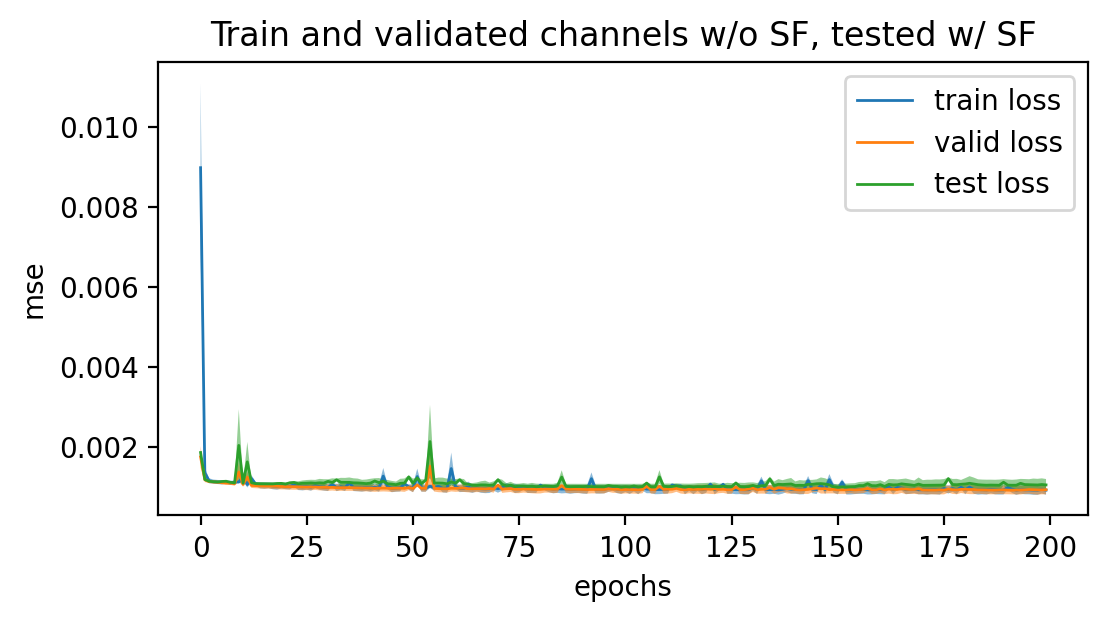

In [117]:

plt.figure(figsize=(6,3),  dpi=200)


for ph, loss in zip(["train", "valid", "test"],[tr_loss, va_loss, te_loss]):
# for ph, loss in zip(["train", "valid", "test"],[tr_wsee, va_wsee, te_wsee]):

    m = np.mean(list(loss.values()),0)
    e = np.std(list(loss.values()),0)

    plt.plot(range(epoch+1), m, '-', linewidth=1, label='%s loss'%ph)
    plt.fill_between(range(epoch+1), m-e, m+e,
        alpha=.5, #edgecolor='#3F7F4C', facecolor='#7EFF99',
        linewidth=0, label=None)


# plt.plot(range(epoch+1), np.mean(list(tr_loss.values()),0), '-', label='train loss')
# plt.plot(range(epoch+1), np.mean(list(va_loss.values()),0), '-', label='validation loss')
# plt.plot(range(epoch+1), np.mean(list(te_loss.values()),0), '-.', label='test loss')

plt.xlabel('epochs')
plt.ylabel('mse')
plt.legend()

# plt.xscale('log')
plt.title('Train and validated channels w/o SF, tested w/ SF')

plt.show()

In [ ]:
ax

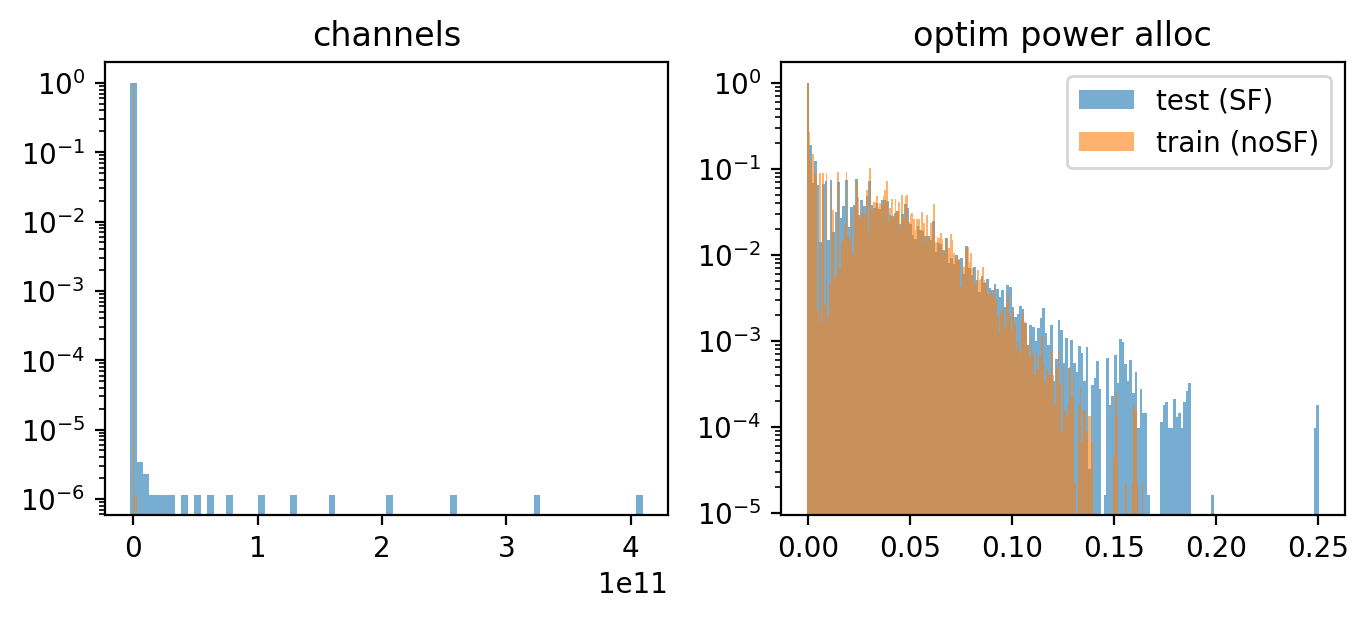

In [60]:
def histogram(sample,bins=10, alpha=1, ax=None, label=None):
    if not bins:
        bins='auto'
    bin_height,bin_boundary = np.histogram(sample,bins=bins)
    width = bin_boundary[1]-bin_boundary[0]
    bin_height = bin_height/float(max(bin_height))
    if ax is not None:
        ax.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)
    else:
        plt.bar(bin_boundary[:-1],bin_height,width = width, alpha=alpha, label=label)


fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=200)#, sharex=False, sharey=False)

histogram(X_va.flatten(),bins=80, alpha=.6, ax=ax[0], label='test')
histogram(X_tr.flatten(),bins=80, alpha=.6, ax=ax[0], label='train')

histogram(y_va.flatten(),bins=200, alpha=.6, ax=ax[1], label='test (SF)')
histogram(y_tr.flatten(),bins=200, alpha=.6, ax=ax[1], label='train (noSF)')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_title("channels")
ax[1].set_title("optim power alloc")

# plt.title("Data - hataUrban")
plt.legend()
plt.show()




In [ ]:
plt.hist(np.random.randn(300,3))


In [ ]:
plt.plot(p_perm, ee[14], '.', label='mlp', alpha=.7)
#     plt.plot(eeval[k],'.', label=k, alpha=.7)
plt.xticks(range(len(Plin))[::5], [np.round(pl,1) for pl in Plin[::5]])
plt.legend()
plt.show()

In [ ]:
p0, Pmax, model.pvar
f(model.pvar.detach().numpy(), h0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(np.array(ll).mean(-1))

ax[1].plot(ee)

plt.show()